3. Zadatak: IV, WoE izračuni:
- Izračunati IV, WoE za svaku varijablu i prikazati u Jupyter Notebooku
- Izdvojiti varijable sa najjačim IV-om i prikazati grafički WoE graf za sve najjače varijable
- Grupirati razrede po kriteriju WoE za najjače varijable
- Objasniti što ste spoznali temeljem ove analize (profili, uzroci, uzročno posljedične veze)
- Predložite kako biste riješili problem vezano uz vaš skup podataka temeljem  IV, WoE analize (što bi trebalo mijenjati, raditi drugačije, gdje je problem uzrok problema, koji su rizični profili … )
- Sve mora biti vidljivo u Jupyter Notebooku, kod i rezultati, kao i komentari
- Objasniti / komentirati nalaze

**Cilj:** Kvantificirati koliko svaka kategorija varijable doprinosi vjerojatnosti da će učenik imati ocjenu **G1 <= 10** (pad).

#### Metodologija Weight of Evidence (WoE) i Information Value (IV)

**WoE (Weight of Evidence)** mjeri povezanost pojedine kategorije unutar jedne varijable s ciljnom varijablom (WoE možemo koristiti samo na kategoričkim varijablama, za kontinuirane potrenbo ih je diskretizirati):
$$WoE = \ln\frac{\%Dobri}{\%Loši}$$

**IV (Information Value)** mjeri ukupnu prediktivnu snagu varijable (služi za odabir atributa koje ćemo uključiti u izradu prediktivnog modela i njihovo rangiranje po važnosti):
$$IV = \sum [(\%Dobri - \%Loši) \times WoE]$$

#### Interpretacija IV vrijednosti:
| IV vrijednost | Snaga prediktora |
|---|---|
| < 0.02 | Vrlo slab utjecaj |
| 0.02 – 0.1 | Slab utjecaj |
| 0.1 – 1.0 | Jak utjecaj |
| > 1.0 | Vrlo jak utjecaj |

**Doprinos analizi:**
- Omogućuje rangiranje varijabli po važnosti za predikciju
- Identificira kategorije koje nose najviše informacija o riziku
- Pomaže u odabiru varijabli za prediktivne modele


---

## 1. Učitavanje podataka i priprema ciljne varijable

**Što radimo:** Učitavamo dataset i kreiramo binarnu ciljnu varijablu gdje:
- `target_G1 = 1` → učenik je pao (G1 <= 10) - "Loši"
- `target_G1 = 0` → učenik je položio (G1 > 10) - "Dobri"

**Doprinos analizi:** WoE/IV metodologija zahtijeva binarnu ciljnu varijablu. Prag 10 odabran je kao granica prolaza/pada.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('../dataset/student-por.csv', sep=';')

print(f"Dimenzije dataseta: {df.shape}")
print(f"Broj učenika: {df.shape[0]}")
print(f"Broj atributa: {df.shape[1]}")

# Kreiranje ciljne varijable: target_G1 = 1 ako je G1 <= 10 (pad/"Loši"), inače 0 ("Dobri")
df['target_G1'] = (df['G1'] <= 10).astype(int)

print("DISTRIBUCIJA CILJNE VARIJABLE")
print("="*60)
print(f"\nBroj učenika s prolazom (G1 > 10):  {(df['target_G1'] == 0).sum()}")
print(f"Broj učenika s padom (G1 <= 10):    {(df['target_G1'] == 1).sum()}")
print(f"\nPostotak učenika s padom: {(df['target_G1'].mean() * 100):.1f}%")


Dimenzije dataseta: (649, 33)
Broj učenika: 649
Broj atributa: 33
DISTRIBUCIJA CILJNE VARIJABLE

Broj učenika s prolazom (G1 > 10):  397
Broj učenika s padom (G1 <= 10):    252

Postotak učenika s padom: 38.8%


---

## 2. Izračun WoE i IV za svaku varijablu

**Što radimo:** Za svaku varijablu (kategoričku ili diskretiziranu kontinuiranu) računamo:
1. **Krostabulaciju** između prediktora i ciljne varijable (kako su međusobno povezani - kako su kategorije koje smo napravili povezane sa "Dobri" ili "Loši")
2. **Postotni udio** "loših" (G1 <= 10) i "dobrih" (G1 > 10) ishoda unutar svake kategorije
3. **WoE** za svaku kategoriju: ln(%Dobri / %Loši)
4. **IV** za cijelu varijablu: Σ[(%Dobri - %Loši) × WoE]

**Doprinos analizi:**
- Identificira koje kategorije unutar svake varijable najviše doprinose riziku pada
- Kvantificira prediktivnu snagu svake varijable
- Omogućuje rangiranje varijabli za odabir u prediktivni model


In [2]:
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Izračunava WoE i IV za pojedinu varijablu.
    
    Parametri:
    -----------
    df : DataFrame - podaci
    feature : str - naziv varijable za analizu
    target : str - naziv ciljne varijable (binarna: 0=Dobri, 1=Loši)
    bins : int - broj binova za diskretizaciju kontinuiranih varijabli (pretvaranje kontinuiranih numeričkih vrijednosti u kategorije)
    
    Povratna vrijednost:
    -----------
    tuple: (woe_df, iv_value)
        - woe_df: DataFrame s WoE i IV po kategorijama
        - iv_value: ukupna IV vrijednost za varijablu
    """
    # Provjera granulacije varijable - dosljedna kategorizacija
    if np.issubdtype(df[feature].dtype, np.number):
        # Provjera broja jedinstvenih vrijednosti
        if df[feature].nunique() <= 10:
            # Varijabla je već diskretna (npr. studytime 1-4, failures 0-3)
            # Koristimo originalne vrijednosti kako ne bismo izgubili informacije
            temp_feature = df[feature]
        else:
            # Varijabla je kontinuirana (npr. absences 0-93)
            # Primjenjujemo qcut za formiranje razreda (binning)
            # 'duplicates=drop' sprječava pogreške kod nula u podacima
            try:
                temp_feature = pd.qcut(df[feature], bins, duplicates='drop')
            except ValueError:
                # Ako qcut ne uspije, koristi cut
                temp_feature = pd.cut(df[feature], bins, duplicates='drop')
    else:
        temp_feature = df[feature]
    
    # Kreiranje krostabulacije
    crosstab = pd.crosstab(temp_feature, df[target])
    
    # Provjeri da imamo obje klase (Dobri i Loši)
    if 0 not in crosstab.columns:
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab[1] = 0
    
    # Preimenovanje stupaca za jasnoću
    crosstab.columns = ['Dobri', 'Loši']
    
    # Izračunaj distribucije (postotke)
    total_dobri = crosstab['Dobri'].sum()
    total_losi = crosstab['Loši'].sum()
    
    # Dodavanje malog epsilona za izbjegavanje dijeljenja s nulom
    epsilon = 0.0001
    
    crosstab['%_Dobri'] = crosstab['Dobri'] / total_dobri
    crosstab['%_Loši'] = crosstab['Loši'] / total_losi
    
    # Zamijeni nule s epsilon za izbjegavanje log(0)
    crosstab['%_Dobri'] = crosstab['%_Dobri'].replace(0, epsilon)
    crosstab['%_Loši'] = crosstab['%_Loši'].replace(0, epsilon)
    
    # Izračunavanje WoE: ln(%Dobri / %Loši)
    crosstab['WoE'] = np.log(crosstab['%_Dobri'] / crosstab['%_Loši'])
    
    # Izračunavanje IV po kategorijama
    crosstab['IV'] = (crosstab['%_Dobri'] - crosstab['%_Loši']) * crosstab['WoE']
    
    iv_value = crosstab['IV'].sum()
    
    return crosstab, iv_value


def get_iv_interpretation(iv):
    """Vraća tekstualnu interpretaciju IV vrijednosti."""
    if iv > 1.0:
        return "Vrlo jak utjecaj"
    elif iv >= 0.1:
        return "Jak utjecaj"
    elif iv >= 0.02:
        return "Slab utjecaj"
    else:
        return "Vrlo slab utjecaj"


# DOSLJEDNA KATEGORIZACIJA
# Varijable s <= 10 jedinstvenih vrijednosti koriste originalne vrijednosti
# Varijable s > 10 jedinstvenih vrijednosti se automatski diskretiziraju s qcut

print("PREGLED GRANULACIJE NUMERIČKIH VARIJABLI")
print("="*60)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    n_unique = df[col].nunique()
    treatment = "originalne vrijednosti" if n_unique <= 10 else "qcut diskretizacija"
    print(f"  {col}: {n_unique} jedinstvenih → {treatment}")

print()

# (isključujemo G1, G2, G3 jer su ciljne/buduće ocjene)
exclude_cols = ['G1', 'G2', 'G3', 'target_G1']
all_features = [col for col in df.columns if col not in exclude_cols]

print(f"Broj varijabli za WoE/IV analizu: {len(all_features)}")
print(f"\nVarijable: {all_features}")


PREGLED GRANULACIJE NUMERIČKIH VARIJABLI
  age: 8 jedinstvenih → originalne vrijednosti
  Medu: 5 jedinstvenih → originalne vrijednosti
  Fedu: 5 jedinstvenih → originalne vrijednosti
  traveltime: 4 jedinstvenih → originalne vrijednosti
  studytime: 4 jedinstvenih → originalne vrijednosti
  failures: 4 jedinstvenih → originalne vrijednosti
  famrel: 5 jedinstvenih → originalne vrijednosti
  freetime: 5 jedinstvenih → originalne vrijednosti
  goout: 5 jedinstvenih → originalne vrijednosti
  Dalc: 5 jedinstvenih → originalne vrijednosti
  Walc: 5 jedinstvenih → originalne vrijednosti
  health: 5 jedinstvenih → originalne vrijednosti
  absences: 24 jedinstvenih → qcut diskretizacija
  G1: 17 jedinstvenih → qcut diskretizacija
  G2: 16 jedinstvenih → qcut diskretizacija
  G3: 17 jedinstvenih → qcut diskretizacija
  target_G1: 2 jedinstvenih → originalne vrijednosti

Broj varijabli za WoE/IV analizu: 30

Varijable: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', '

In [3]:
iv_results = []
woe_tables = {}

print("IZRAČUN WoE I IV ZA SVE VARIJABLE...")
print("="*80)

for feature in all_features:
    try:
        woe_df, iv_value = calculate_woe_iv(df, feature, 'target_G1', bins=5)
        woe_tables[feature] = woe_df
        
        iv_results.append({
            'Varijabla': feature,
            'IV': round(iv_value, 4),
            'Prediktivnost': get_iv_interpretation(iv_value)
        })
    except Exception as e:
        print(f"Greška za {feature}: {e}")

# Kreiraj DataFrame s rezultatima, sortiraj po IV silazno
iv_df = pd.DataFrame(iv_results)
iv_df = iv_df.sort_values('IV', ascending=False).reset_index(drop=True)

print("TABLICA IV VRIJEDNOSTI ZA SVE VARIJABLE (sortirano silazno)")
print("\nVarijable s IV > 0.1 smatraju se značajnima (jak utjecaj) za predikciju pada.\n")

display(iv_df)

iv_df.to_csv('WoE_IV_rezultati.csv', index=False, sep=';')
print("\n Rezultati spremljeni u 'WoE_IV_rezultati.csv'")


IZRAČUN WoE I IV ZA SVE VARIJABLE...
TABLICA IV VRIJEDNOSTI ZA SVE VARIJABLE (sortirano silazno)

Varijable s IV > 0.1 smatraju se značajnima (jak utjecaj) za predikciju pada.



,Varijabla,IV,Prediktivnost
0,failures,0.8696,Jak utjecaj
1,higher,0.5162,Jak utjecaj
2,school,0.4156,Jak utjecaj
3,Medu,0.2648,Jak utjecaj
4,age,0.2360,Jak utjecaj
5,studytime,0.2147,Jak utjecaj
6,Dalc,0.2017,Jak utjecaj
7,Mjob,0.1797,Jak utjecaj
8,Fedu,0.1600,Jak utjecaj
9,reason,0.1543,Jak utjecaj



 Rezultati spremljeni u 'WoE_IV_rezultati.csv'


---

## 3. Izdvajanje varijabli za grupiranje (binning analizu)

### Kriteriji odabira:
1. **IV >= 0.1** (jak utjecaj) - samo varijable s značajnom prediktivnom snagom
2. **Više od 2 vrijednosti** - isključujemo binarne varijable jer ih nema smisla grupirati

### Zašto isključujemo binarne varijable?
Binarne varijable (npr. sex=M/F, higher=yes/no) već su u najjednostavnijem obliku.
Nema smisla ih "grupirati" jer imaju samo 2 kategorije.

**Interpretacija WoE grafikona:**
- **Negativniji WoE** (ispod nule) → kategorije s većim rizikom pada
- **Pozitivniji WoE** (iznad nule) → kategorije s manjim rizikom pada
- **Veća apsolutna vrijednost** → jači utjecaj kategorije na ishod

VARIJABLE S JAKIM UTJECAJEM (IV >= 0.1) I VIŠE OD 2 VRIJEDNOSTI

Isključene binarne varijable (2 vrijednosti) jer ih nema smisla grupirati.

Broj varijabli za detaljnu analizu: 11



,Varijabla,IV,Prediktivnost,Broj_vrijednosti
0,failures,0.8696,Jak utjecaj,4
3,Medu,0.2648,Jak utjecaj,5
4,age,0.2360,Jak utjecaj,8
5,studytime,0.2147,Jak utjecaj,4
6,Dalc,0.2017,Jak utjecaj,5
7,Mjob,0.1797,Jak utjecaj,5
8,Fedu,0.1600,Jak utjecaj,5
9,reason,0.1543,Jak utjecaj,4
10,traveltime,0.1311,Jak utjecaj,4
12,absences,0.1078,Jak utjecaj,24


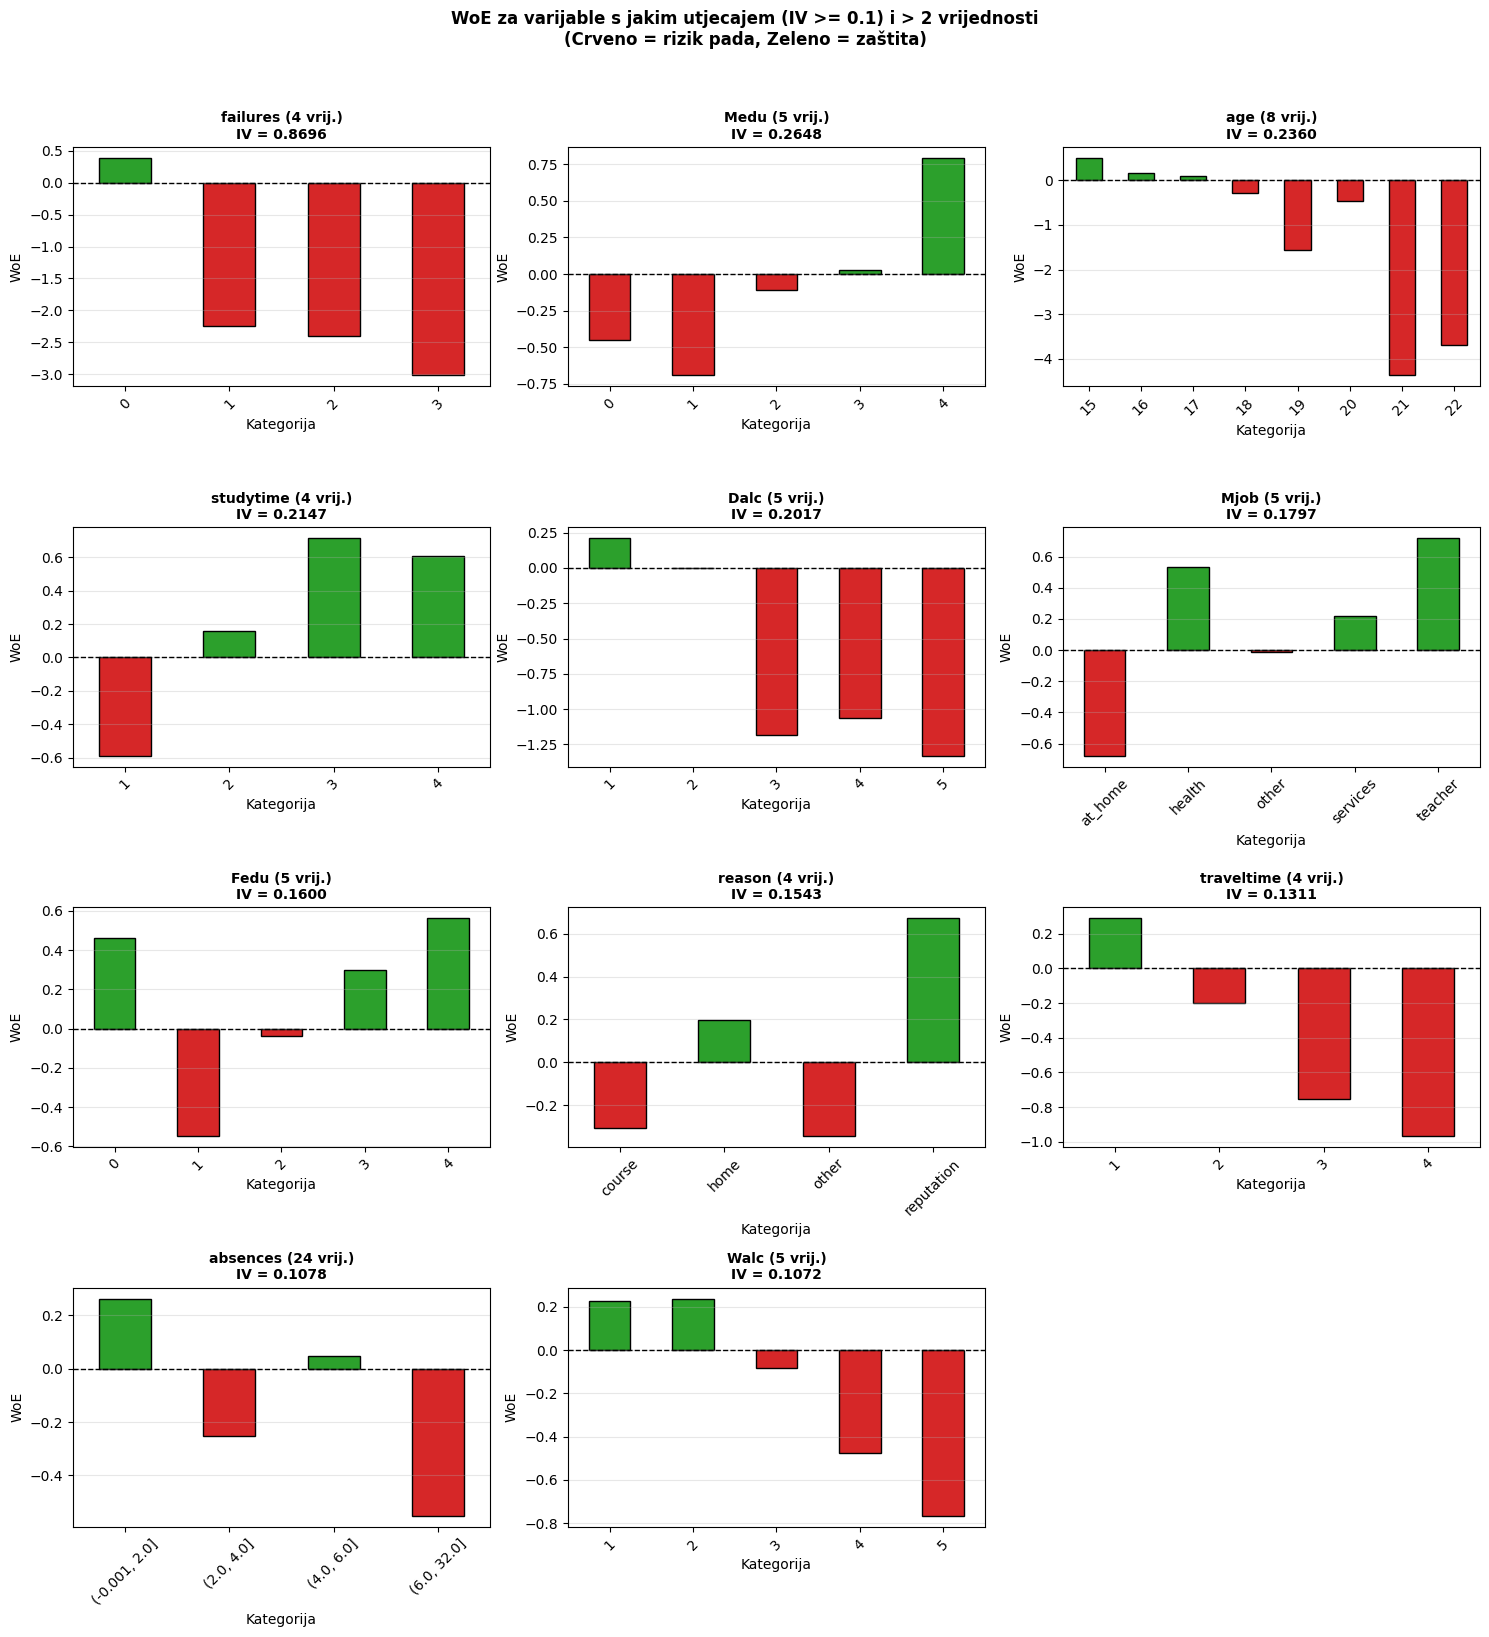

In [4]:
# Izdvajanje varijabli s jakim utjecajem (IV >= 0.1) i više od 2 vrijednosti
# Binarne varijable isključujemo jer ih nema smisla grupirati

import math

# Kreiraj listu varijabli s brojem jedinstvenih vrijednosti
var_unique_counts = {}
for feature in all_features:
    var_unique_counts[feature] = df[feature].nunique()

# Filtriraj: IV >= 0.1 (jak utjecaj) I više od 2 jedinstvene vrijednosti
strong_features = iv_df[
    (iv_df['IV'] >= 0.1) & 
    (iv_df['Varijabla'].apply(lambda x: var_unique_counts.get(x, 0) > 2))
].copy()

# Dodaj stupac s brojem vrijednosti
strong_features['Broj_vrijednosti'] = strong_features['Varijabla'].apply(lambda x: var_unique_counts.get(x, 0))

print("VARIJABLE S JAKIM UTJECAJEM (IV >= 0.1) I VIŠE OD 2 VRIJEDNOSTI")
print("="*80)
print("\nIsključene binarne varijable (2 vrijednosti) jer ih nema smisla grupirati.")
print(f"\nBroj varijabli za detaljnu analizu: {len(strong_features)}\n")
display(strong_features)

# Koristi strong_features za daljnju analizu
top_features = strong_features

# Kreiranje grafikona WoE - dinamički broj subplotova
n_features = len(top_features)
if n_features > 0:
    n_cols = min(3, n_features)
    n_rows = math.ceil(n_features / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Osiguraj da je axes lista
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    
    for i, (idx, row) in enumerate(top_features.iterrows()):
        feature = row['Varijabla']
        iv_value = row['IV']
        n_vals = row['Broj_vrijednosti']
        
        woe_df = woe_tables[feature]
        
        ax = axes[i]
        colors = ['#d62728' if x < 0 else '#2ca02c' for x in woe_df['WoE'].values]
        woe_df['WoE'].plot(kind='bar', ax=ax, color=colors, edgecolor='black')
        
        ax.set_title(f'{feature} ({n_vals} vrij.)\nIV = {iv_value:.4f}', 
                     fontsize=10, fontweight='bold')
        ax.set_xlabel('Kategorija')
        ax.set_ylabel('WoE')
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Sakrij prazne subplotove
    for j in range(n_features, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('WoE za varijable s jakim utjecajem (IV >= 0.1) i > 2 vrijednosti\n(Crveno = rizik pada, Zeleno = zaštita)', 
                 fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Nema varijabli koje zadovoljavaju kriterije.")

Primjer čitanja: 
| Varijabla = Vrijednost | Objašnjenje |
| :--- | :--- |
| **Broj dobrih = 297** | U ovom binu nalazi se 297 dobrih slučajeva (npr. studenti koji prolaze, imaju G > 10). |
| **Broj loših = 220** | U ovom binu nalazi se 220 loših slučajeva (studenti koji padaju, imaju G ≤ 10). |
| **Postotak dobrih = 0.748 (74.8%)** | 74.8% svih dobrih studenata nalazi se u ovom binu. |
| **Postotak loših = 0.873 (87.3%)** | 87.3% svih loših studenata nalazi se u ovom binu. |
| **WoE = -0.154** | U ovom binu ima relativno više loših nego dobrih; bin ima negativan utjecaj (rizičan bin). |
| **IV = 0.019** | Ovaj bin slabo doprinosi razdvajanju dobrih i loših. |

---

## 4. Grupiranje razreda (Binning) prema kriteriju WoE

**Što radimo:**
1. Na temelju WoE grafova identificiramo susjedne kategorije koje imaju slične WoE vrijednosti
2. Spajamo te kategorije u nove, šire razrede
3. Ponovno izračunavamo IV i WoE za nove grupe

**Cilj:**
- Veća stabilnost varijable spajanjem kategorija koje imaju sličan utjecaj na ciljnu varijablu
- Smanjiti šum i povećati robusnost prediktora
- Postići linearniji trend rizika

**Doprinos analizi:**
- Redizajnirani atributi s optimiziranim brojem razreda
- Jednostavniji model s manje kategorija
- Bolji "signal-to-noise" ratio u varijablama


GRUPIRANJE RAZREDA PO KRITERIJU WoE - VARIJABLE S JAKIM UTJECAJEM (IV >= 0.1)
Varijable za grupiranje (IV >= 0.1, > 2 vrijednosti): 11

Isključene binarne varijable jer ih nema smisla grupirati.



,Varijabla,IV,Prediktivnost,Broj_vrijednosti
0,failures,0.8696,Jak utjecaj,4
3,Medu,0.2648,Jak utjecaj,5
4,age,0.2360,Jak utjecaj,8
5,studytime,0.2147,Jak utjecaj,4
6,Dalc,0.2017,Jak utjecaj,5
7,Mjob,0.1797,Jak utjecaj,5
8,Fedu,0.1600,Jak utjecaj,5
9,reason,0.1543,Jak utjecaj,4
10,traveltime,0.1311,Jak utjecaj,4
12,absences,0.1078,Jak utjecaj,24




  VARIJABLA: FAILURES (IV = 0.8696)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
failures,,,,,,
0,384,165,0.3902,0.1219,549,84.6
1,10,60,-2.2463,0.4782,70,10.8
2,2,14,-2.4004,0.1213,16,2.5
3,1,13,-3.0195,0.1482,14,2.2



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
0,384,165,0.3902,0.1219,549,84.6
1-3,13,87,-2.3555,0.7361,100,15.4



 IV usporedba: 0.8696 → 0.8580 (gubitak: 0.0116, tj. 1.3%)


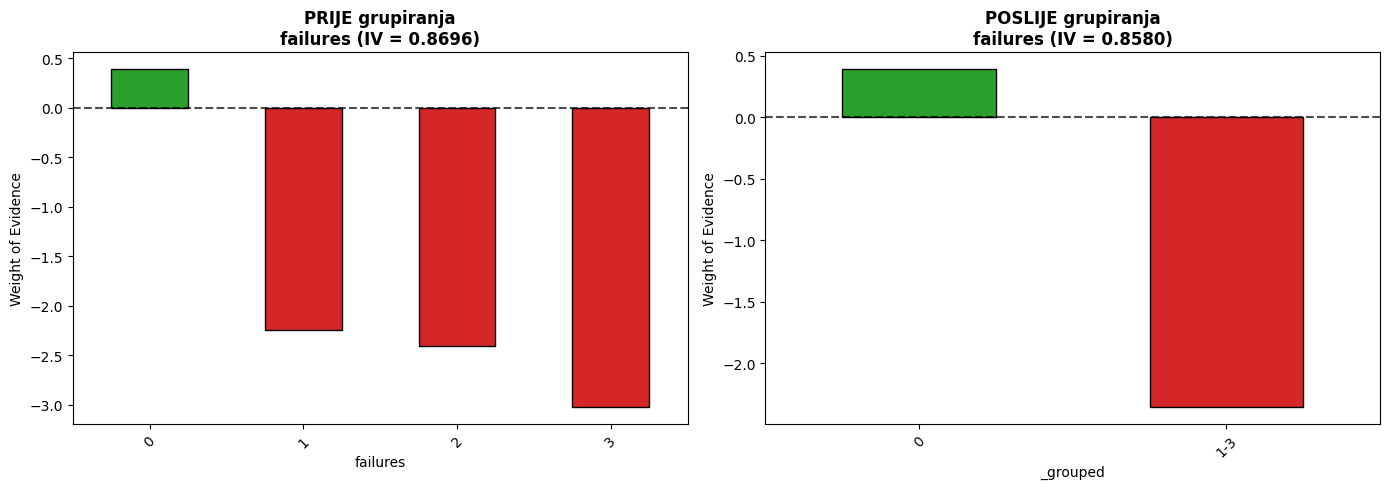


  VARIJABLA: MEDU (IV = 0.2648)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
Medu,,,,,,
0,3,3,-0.4545,0.0020,6,0.9
1,63,80,-0.6934,0.1101,143,22.0
2,109,77,-0.1070,0.0033,186,28.7
3,86,53,0.0295,0.0002,139,21.4
4,136,39,0.7946,0.1492,175,27.0



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
0-1,66,83,-0.6837,0.1115,149,23.0
2-3,195,130,-0.0490,0.0012,325,50.1
4,136,39,0.7946,0.1492,175,27.0



 IV usporedba: 0.2648 → 0.2620 (gubitak: 0.0028, tj. 1.1%)


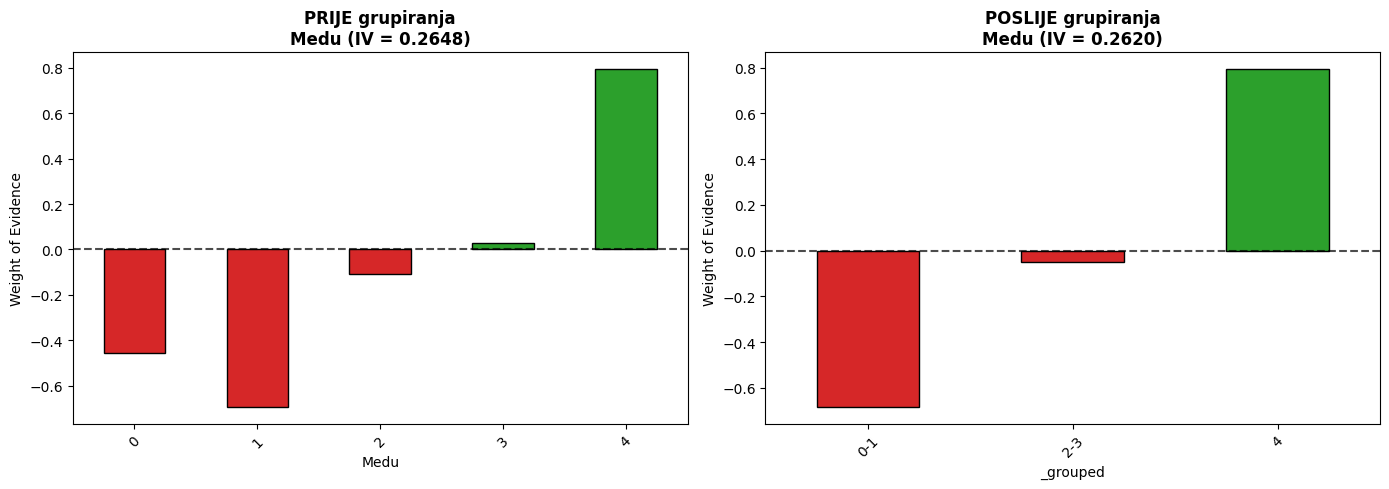


  VARIJABLA: AGE (IV = 0.2360)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
age,,,,,,
15,81,31,0.5060,0.0410,112,17.3
16,115,62,0.1633,0.0071,177,27.3
17,114,65,0.1073,0.0031,179,27.6
18,76,64,-0.2827,0.0177,140,21.6
19,8,24,-1.5531,0.1166,32,4.9
20,3,3,-0.4545,0.0020,6,0.9
21,0,2,-4.3741,0.0343,2,0.3
22,0,1,-3.6809,0.0142,1,0.2



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
15,81,31,0.5060,0.0410,112,17.3
16-17,229,127,0.1350,0.0098,356,54.9
18,76,64,-0.2827,0.0177,140,21.6
19-22,11,30,-1.4578,0.1332,41,6.3



 IV usporedba: 0.2360 → 0.2017 (gubitak: 0.0344, tj. 14.6%)


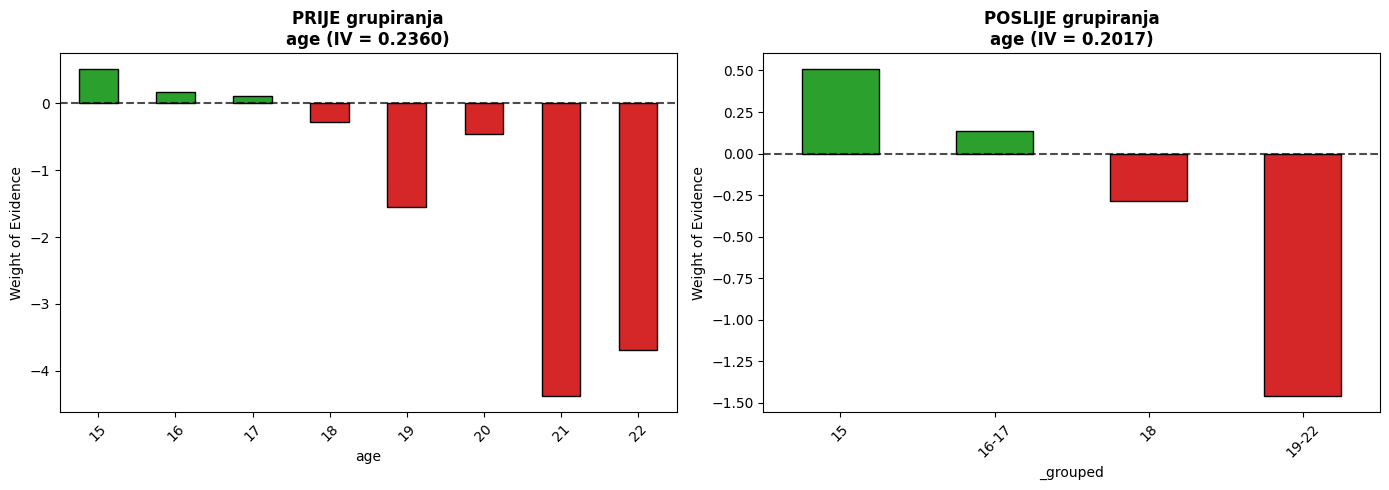


  VARIJABLA: STUDYTIME (IV = 0.2147)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
studytime,,,,,,
1,99,113,-0.5868,0.1168,212,32.7
2,198,107,0.1609,0.0119,305,47.0
3,74,23,0.7141,0.0679,97,14.9
4,26,9,0.6064,0.0181,35,5.4



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
1,99,113,-0.5868,0.1168,212,32.7
2,198,107,0.1609,0.0119,305,47.0
3-4,100,32,0.6849,0.0856,132,20.3



 IV usporedba: 0.2147 → 0.2143 (gubitak: 0.0004, tj. 0.2%)


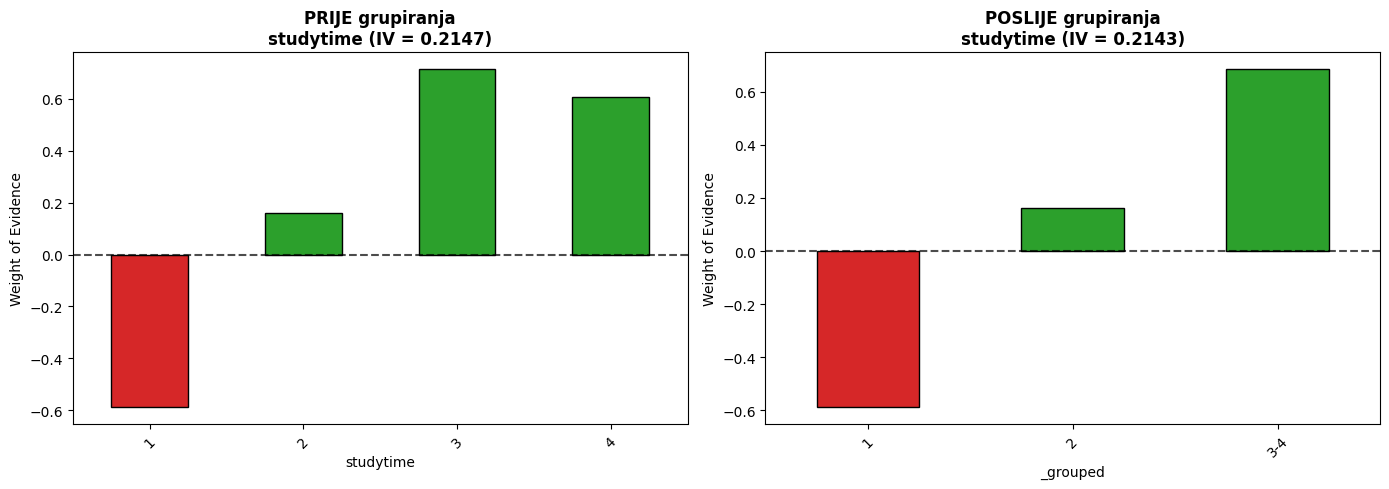


  VARIJABLA: DALC (IV = 0.2017)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
Dalc,,,,,,
1,298,153,0.2121,0.0304,451,69.5
2,74,47,-0.0006,0.0000,121,18.6
3,14,29,-1.1827,0.0944,43,6.6
4,6,11,-1.0606,0.0303,17,2.6
5,5,12,-1.3300,0.0466,17,2.6



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
1-2,372,200,0.1661,0.0238,572,88.1
3-5,25,52,-1.1869,0.1702,77,11.9



 IV usporedba: 0.2017 → 0.1940 (gubitak: 0.0077, tj. 3.8%)


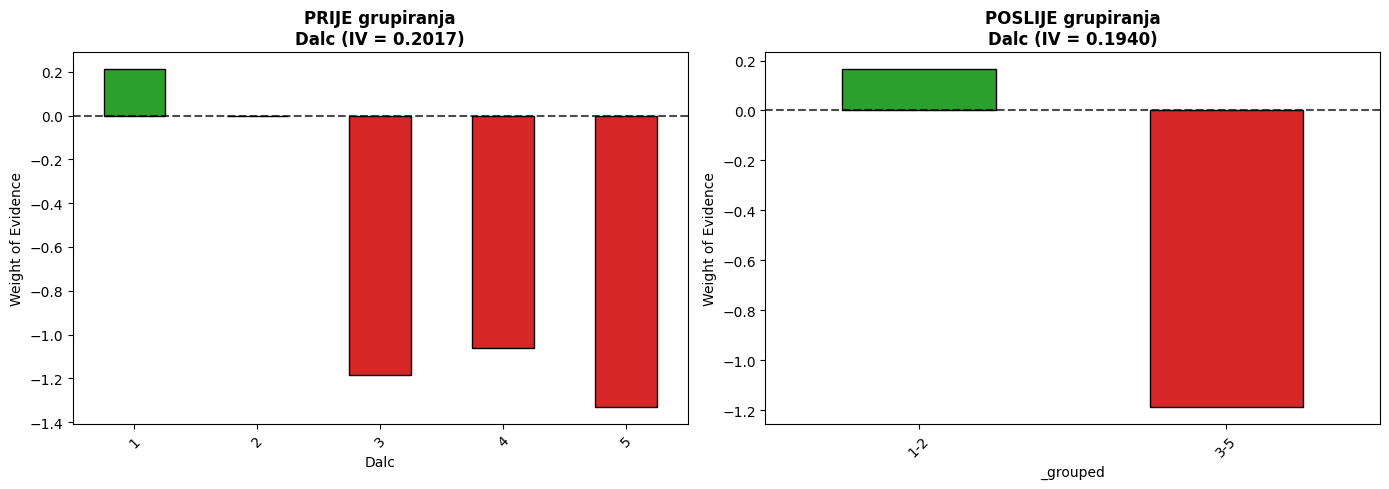


  VARIJABLA: MJOB (IV = 0.1797)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
Mjob,,,,,,
at_home,60,75,-0.6777,0.0993,135,20.8
health,35,13,0.5359,0.0196,48,7.4
other,157,101,-0.0134,0.0001,258,39.8
services,90,46,0.2167,0.0096,136,21.0
teacher,55,17,0.7196,0.0511,72,11.1



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
at_home,60,75,-0.6777,0.0993,135,20.8
health-teacher,90,30,0.6441,0.0693,120,18.5
other-services,247,147,0.0644,0.0025,394,60.7



 IV usporedba: 0.1797 → 0.1711 (gubitak: 0.0085, tj. 4.8%)


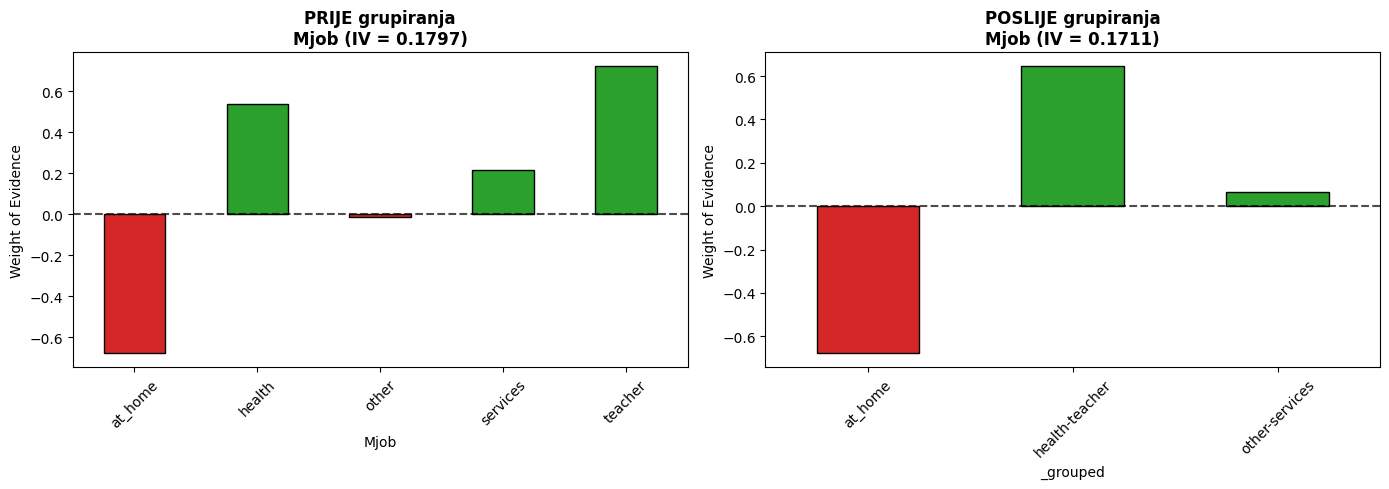


  VARIJABLA: FEDU (IV = 0.1600)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
Fedu,,,,,,
0,5,2,0.4618,0.0022,7,1.1
1,83,91,-0.5465,0.0831,174,26.8
2,126,83,-0.0371,0.0004,209,32.2
3,89,42,0.2965,0.0171,131,20.2
4,94,34,0.5624,0.0573,128,19.7



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
0-1,88,93,-0.5098,0.0751,181,27.9
2,126,83,-0.0371,0.0004,209,32.2
3-4,183,76,0.4242,0.0676,259,39.9



 IV usporedba: 0.1600 → 0.1432 (gubitak: 0.0168, tj. 10.5%)


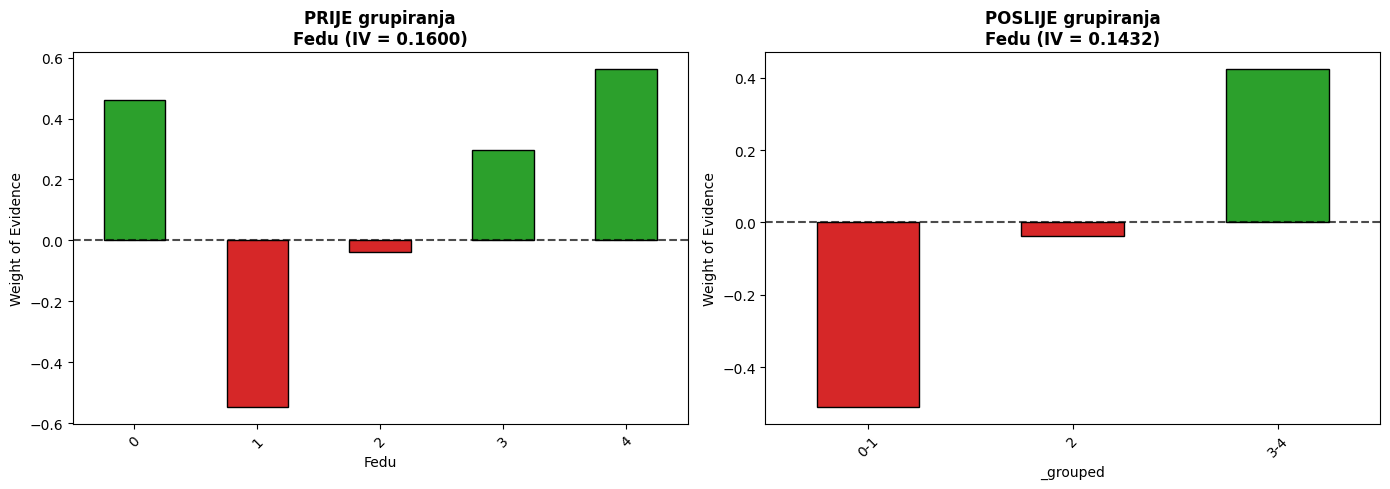


  VARIJABLA: REASON (IV = 0.1543)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
reason,,,,,,
course,153,132,-0.3069,0.0425,285,43.9
home,98,51,0.1986,0.0088,149,23.0
other,38,34,-0.3433,0.0135,72,11.1
reputation,108,35,0.6723,0.0895,143,22.0



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
home,98,51,0.1986,0.0088,149,23.0
other-course,191,166,-0.3142,0.0558,357,55.0
reputation,108,35,0.6723,0.0895,143,22.0



 IV usporedba: 0.1543 → 0.1542 (gubitak: 0.0001, tj. 0.1%)


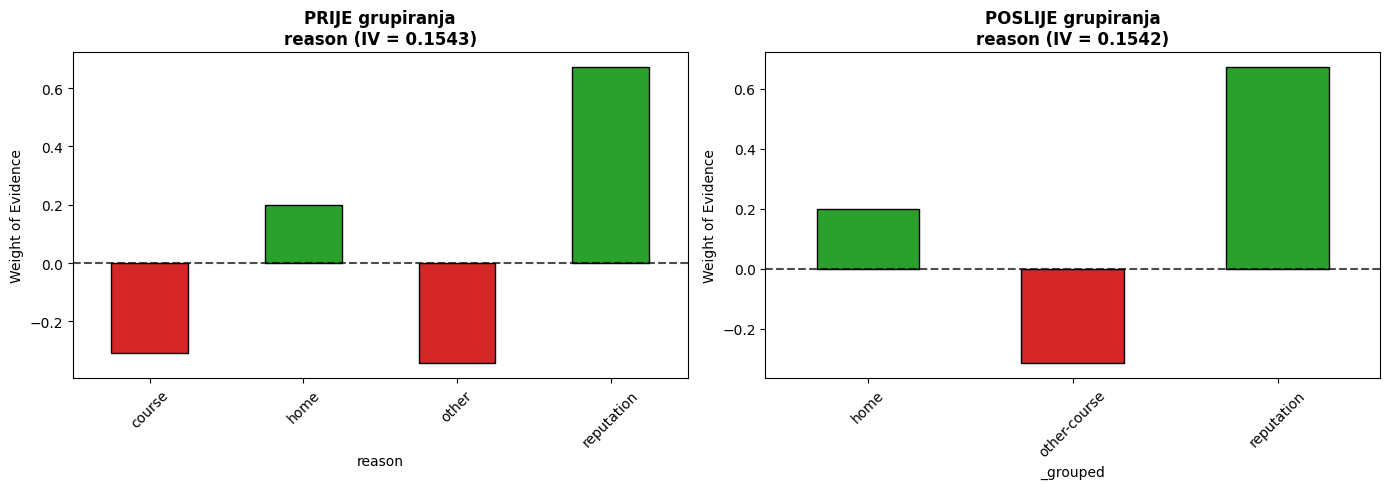


  VARIJABLA: TRAVELTIME (IV = 0.1311)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
traveltime,,,,,,
1,248,118,0.2882,0.0451,366,56.4
2,120,93,-0.1996,0.0133,213,32.8
3,23,31,-0.7530,0.0490,54,8.3
4,6,10,-0.9653,0.0237,16,2.5



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
1,248,118,0.2882,0.0451,366,56.4
2,120,93,-0.1996,0.0133,213,32.8
3-4,29,41,-0.8008,0.0718,70,10.8



 IV usporedba: 0.1311 → 0.1302 (gubitak: 0.0009, tj. 0.7%)


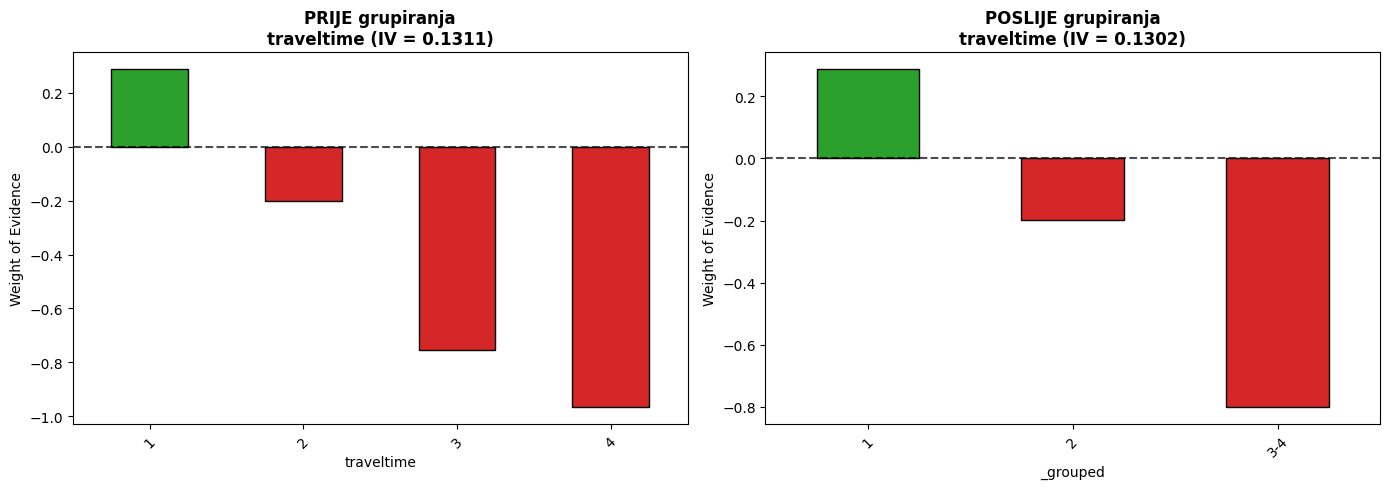


  VARIJABLA: ABSENCES (IV = 0.1078)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
absences,,,,,,
"(-0.001, 2.0]",246,120,0.2633,0.0378,366,56.4
"(2.0, 4.0]",55,45,-0.2538,0.0102,100,15.4
"(4.0, 6.0]",38,23,0.0476,0.0002,61,9.4
"(6.0, 32.0]",58,64,-0.5529,0.0596,122,18.8



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
"(-0.001, 2.0]",246,120,0.2633,0.0378,366,56.4
"(2.0, 4.0]",55,45,-0.2538,0.0102,100,15.4
"(4.0, 6.0]",38,23,0.0476,0.0002,61,9.4
"(6.0, 32.0]",58,64,-0.5529,0.0596,122,18.8



 IV usporedba: 0.1078 → 0.1078 (gubitak: 0.0000, tj. 0.0%)


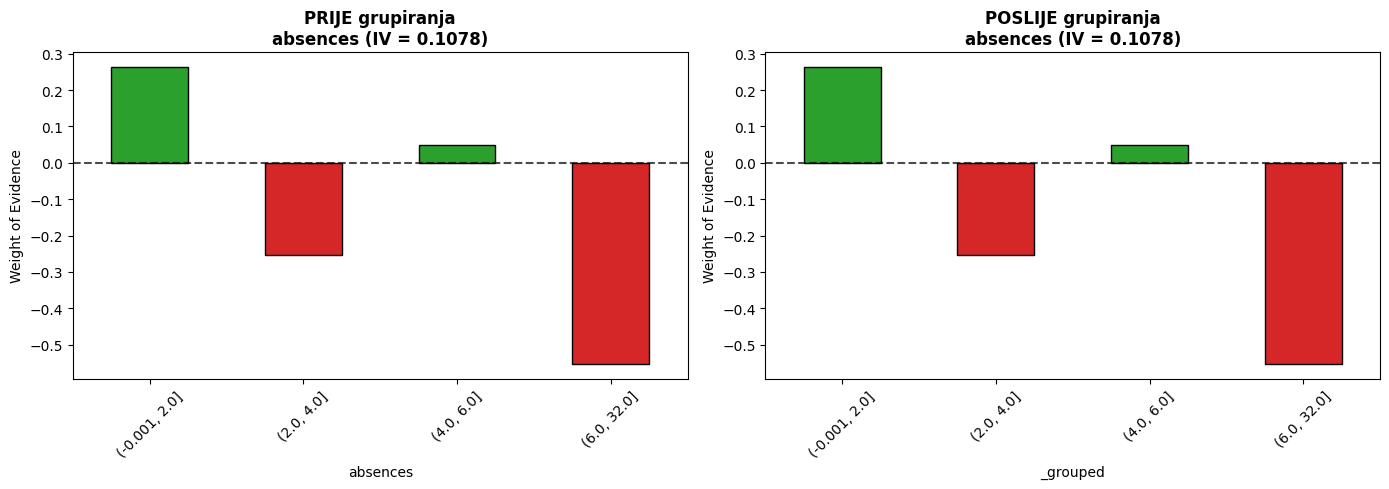


  VARIJABLA: WALC (IV = 0.1072)

 PRIJE GRUPIRANJA (min. veličina grupe = 32 učenika, tj. 5%):


,Dobri,Loši,WoE,IV,N,%
Walc,,,,,,
1,164,83,0.2265,0.0190,247,38.1
2,100,50,0.2386,0.0128,150,23.1
3,71,49,-0.0836,0.0013,120,18.5
4,43,44,-0.4775,0.0317,87,13.4
5,19,26,-0.7682,0.0425,45,6.9



 POSLIJE GRUPIRANJA:


,Dobri,Loši,WoE,IV,N,%
_grouped,,,,,,
1-2,264,133,0.2311,0.0317,397,61.2
3,71,49,-0.0836,0.0013,120,18.5
4-5,62,70,-0.5759,0.0700,132,20.3



 IV usporedba: 0.1072 → 0.1030 (gubitak: 0.0041, tj. 3.9%)


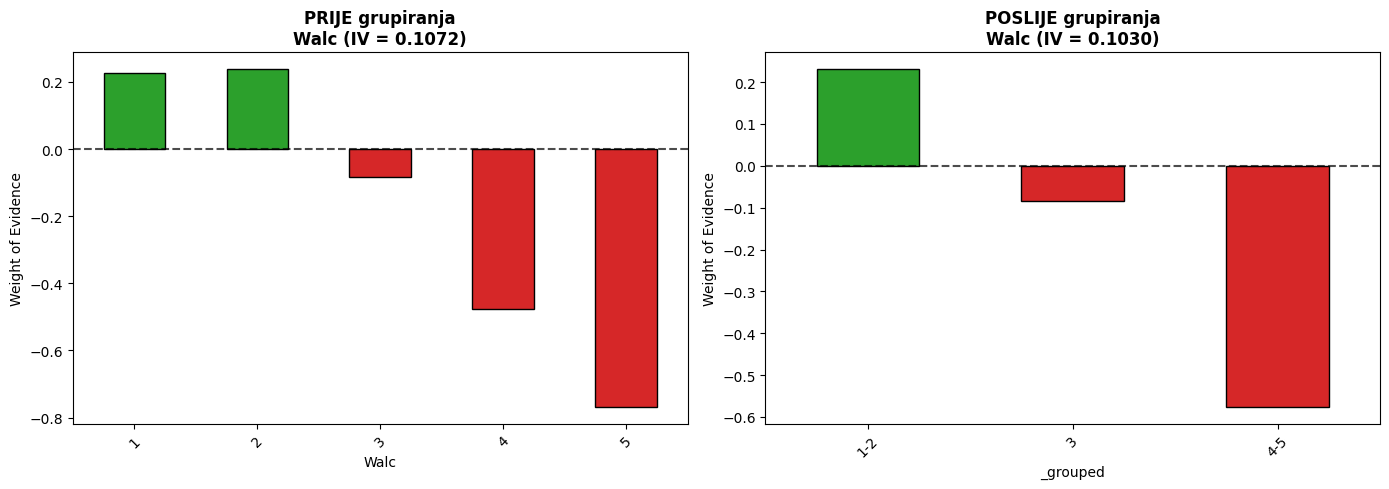


SAŽETAK GRUPIRANJA

Grupiranje po WoE kriteriju omogućuje:
  1. Jednostavniji model s manje kategorija
  2. Stabilnije predviđanje (manje prekomjernog prilagođavanja)
  3. Jasniju interpretaciju rizičnih profila


In [5]:
# "Grupirati razrede po kriteriju WoE za najjače varijable"
# 
# PRAVILA GRUPIRANJA (prema metodologiji):
# 1. Samo susjedni razredi - ne preskakati vrijednosti
# 2. Minimalna veličina grupe - barem 5% uzorka (~30 učenika)
# 3. Linearni trend - nakon grupiranja WoE treba pratiti logičan trend
# 4. Minimalan gubitak IV-a

def group_by_woe(df, feature, target, min_pct=0.05, woe_similar_threshold=0.3, woe_max_diff=0.6):
    """
    df : DataFrame - podaci
    feature : str - naziv varijable
    target : str - naziv ciljne varijable
    min_pct : float - minimalni postotak uzorka po grupi (default 5%)
    woe_similar_threshold : float - prag za "sličan" WoE (default 0.3)
    woe_max_diff : float - maksimalna razlika WoE za spajanje (default 0.6)
    
    Povratna vrijednost:
    -----------
    tuple: (grouped_feature, woe_before, woe_after, mapping, iv_before, iv_after)
    """
    # Izračunaj WoE za originalne kategorije
    woe_before, iv_before = calculate_woe_iv(df, feature, target)
    
    # Minimalna veličina grupe
    min_count = int(len(df) * min_pct)
    
    # Provjeri je li varijabla numerička ili kategorička
    is_ordinal = np.issubdtype(df[feature].dtype, np.number)
    
    if is_ordinal:
        # Za numeričke varijable: sortiraj po vrijednosti (ne po WoE!)
        categories = sorted(woe_before.index.tolist())
    else:
        # Za kategoričke varijable: sortiraj po WoE (nema prirodnog poretka)
        categories = woe_before['WoE'].sort_values().index.tolist()
    
    # Dodaj broj observacija u WoE tablicu
    woe_before['N'] = woe_before['Dobri'] + woe_before['Loši']
    
    # Početne grupe - svaka kategorija je zasebna grupa
    groups = [[cat] for cat in categories]
    group_counts = [woe_before.loc[cat, 'N'] for cat in categories]
    
    def get_group_woe(group):
        """Izračunaj prosječni WoE grupe (ponderirano brojem uzoraka)"""
        total_n = sum(woe_before.loc[c, 'N'] for c in group)
        if total_n == 0:
            return 0
        weighted_woe = sum(woe_before.loc[c, 'WoE'] * woe_before.loc[c, 'N'] for c in group)
        return weighted_woe / total_n
    
    # KORAK 1: Spoji SAMO male uzorke sa susjedom koji ima NAJSLIČNIJI WoE
    # Ali samo ako razlika nije prevelika!
    changed = True
    iterations = 0
    max_iterations = 100  # Zaštita od beskonačne petlje
    
    while changed and iterations < max_iterations:
        changed = False
        iterations += 1
        
        for i in range(len(groups)):
            if group_counts[i] < min_count:
                # Grupa je premala - pronađi najboljeg susjeda
                woe_current = get_group_woe(groups[i])
                
                candidates = []
                
                # Prethodni susjed
                if i > 0:
                    woe_prev = get_group_woe(groups[i-1])
                    diff_prev = abs(woe_current - woe_prev)
                    candidates.append((i-1, diff_prev, 'prev'))
                
                # Sljedeći susjed
                if i < len(groups) - 1:
                    woe_next = get_group_woe(groups[i+1])
                    diff_next = abs(woe_current - woe_next)
                    candidates.append((i+1, diff_next, 'next'))
                
                if not candidates:
                    continue
                
                # Sortiranje po sličnosti WoE (manji diff = bolji)
                candidates.sort(key=lambda x: x[1])
                best_idx, best_diff, direction = candidates[0]
                
                # Spajanje s najboljim susjedom (čak i ako je diff velik - moramo riješiti mali uzorak)
                if direction == 'prev':
                    groups[best_idx].extend(groups[i])
                    group_counts[best_idx] += group_counts[i]
                    del groups[i]
                    del group_counts[i]
                else:
                    groups[i].extend(groups[best_idx])
                    group_counts[i] += group_counts[best_idx]
                    del groups[best_idx]
                    del group_counts[best_idx]
                
                changed = True
                break
    
    # KORAK 2: Dodatno grupiranje SAMO susjedne kategorije sa SLIČNIM WoE (diff <= woe_similar_threshold)
    # Ovo je opcionalno poboljšanje, ne forsiramo ga
    changed = True
    while changed and len(groups) > 2:  # Zadrži barem 2 grupe
        changed = False
        best_merge = None
        best_diff = float('inf')
        
        for i in range(len(groups) - 1):
            woe_current = get_group_woe(groups[i])
            woe_next = get_group_woe(groups[i+1])
            diff = abs(woe_current - woe_next)
            
            # Spoji samo ako je razlika MALA (sličan WoE)
            if diff <= woe_similar_threshold and diff < best_diff:
                best_merge = i
                best_diff = diff
        
        if best_merge is not None:
            i = best_merge
            groups[i].extend(groups[i+1])
            group_counts[i] += group_counts[i+1]
            del groups[i+1]
            del group_counts[i+1]
            changed = True
    
    # Kreiraj mapping originalnih kategorija na nove grupe
    mapping = {}
    for group in groups:
        if len(group) == 1:
            group_name = str(group[0])
        else:
            # Sortiraj grupu za konzistentan naziv
            sorted_group = sorted(group) if is_ordinal else group
            group_name = f"{sorted_group[0]}-{sorted_group[-1]}"
        for cat in group:
            mapping[cat] = group_name
    
    # grupiranje
    grouped_feature = df[feature].map(mapping)
    
    # Računanje WoE za grupirane kategorije (IZNOVA od početnih podataka!)
    temp_df = df.copy()
    temp_df['_grouped'] = grouped_feature
    woe_after, iv_after = calculate_woe_iv(temp_df, '_grouped', target)
    
    return grouped_feature, woe_before, woe_after, mapping, iv_before, iv_after


print("="*100)
print("GRUPIRANJE RAZREDA PO KRITERIJU WoE - VARIJABLE S JAKIM UTJECAJEM (IV >= 0.1)")
print("="*100)

# Broj jedinstvenih vrijednosti za svaku varijablu
var_unique_counts = {col: df[col].nunique() for col in all_features}

# Primijeni sve filtere
grouping_features = iv_df[
    (iv_df['IV'] >= 0.1) &  # Jak utjecaj
    (iv_df['Varijabla'].apply(lambda x: var_unique_counts.get(x, 0) > 2))  # Više od 2 vrijednosti
].copy()

# Dodaj broj vrijednosti za prikaz
grouping_features['Broj_vrijednosti'] = grouping_features['Varijabla'].apply(lambda x: var_unique_counts.get(x, 0))

print(f"Varijable za grupiranje (IV >= 0.1, > 2 vrijednosti): {len(grouping_features)}")
print("\nIsključene binarne varijable jer ih nema smisla grupirati.\n")
display(grouping_features)
print()

# Rječnik za spremanje grupiranih varijabli
grouped_mappings = {}

for idx, row in grouping_features.iterrows():
    feature = row['Varijabla']
    original_iv = row['IV']
    
    print("\n" + "="*100)
    print(f"  VARIJABLA: {feature.upper()} (IV = {original_iv:.4f})")
    print("="*100)
    
    # Provjeri je li varijabla u woe_tables
    if feature not in woe_tables:
        print(f"   Varijabla '{feature}' nije pronađena u WoE tablicama. Preskačem...")
        continue
    
    # Primijeni grupiranje s pametnim pragovima:
    # - min_pct=0.05: minimalno 5% uzorka po grupi (stabilnost)
    # - woe_similar_threshold=0.3: spoji samo ako je WoE razlika <= 0.3 (sličnost)
    # - woe_max_diff=0.6: upozorenje ako spajamo kategorije s razlikom > 0.6
    grouped_feat, woe_before, woe_after, mapping, iv_before, iv_after = group_by_woe(
        df, feature, 'target_G1', 
        min_pct=0.05, 
        woe_similar_threshold=0.3,
        woe_max_diff=0.6
    )
    
    grouped_mappings[feature] = mapping
    
    # Prikaz WoE tablica s brojem uzoraka
    min_required = int(len(df) * 0.05)
    print(f"\n PRIJE GRUPIRANJA (min. veličina grupe = {min_required} učenika, tj. 5%):")
    
    # Dodaj kolonu N i % ako nije prisutna
    woe_display = woe_before[['Dobri', 'Loši', 'WoE', 'IV']].copy()
    woe_display['N'] = woe_before['Dobri'] + woe_before['Loši']
    woe_display['%'] = (woe_display['N'] / len(df) * 100).round(1)
    display(woe_display.round(4))
    
    print("\n POSLIJE GRUPIRANJA:")
    woe_after_display = woe_after[['Dobri', 'Loši', 'WoE', 'IV']].copy()
    woe_after_display['N'] = woe_after['Dobri'] + woe_after['Loši']
    woe_after_display['%'] = (woe_after_display['N'] / len(df) * 100).round(1)
    display(woe_after_display.round(4))
    
    # Provjera IV gubitka
    iv_loss = iv_before - iv_after
    iv_loss_pct = (iv_loss / iv_before * 100) if iv_before > 0 else 0
    print(f"\n IV usporedba: {iv_before:.4f} → {iv_after:.4f} (gubitak: {iv_loss:.4f}, tj. {iv_loss_pct:.1f}%)")
    
    # Vizualizacija: PRIJE i POSLIJE
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graf PRIJE
    colors_before = ['#d62728' if x < 0 else '#2ca02c' for x in woe_before['WoE'].values]
    woe_before['WoE'].plot(kind='bar', ax=axes[0], color=colors_before, edgecolor='black')
    axes[0].set_title(f"PRIJE grupiranja\n{feature} (IV = {iv_before:.4f})", fontweight='bold')
    axes[0].set_ylabel('Weight of Evidence')
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Graf POSLIJE
    colors_after = ['#d62728' if x < 0 else '#2ca02c' for x in woe_after['WoE'].values]
    woe_after['WoE'].plot(kind='bar', ax=axes[1], color=colors_after, edgecolor='black')
    axes[1].set_title(f"POSLIJE grupiranja\n{feature} (IV = {iv_after:.4f})", fontweight='bold')
    axes[1].set_ylabel('Weight of Evidence')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*100)
print("SAŽETAK GRUPIRANJA")
print("="*100)
print("\nGrupiranje po WoE kriteriju omogućuje:")
print("  1. Jednostavniji model s manje kategorija")
print("  2. Stabilnije predviđanje (manje prekomjernog prilagođavanja)")
print("  3. Jasniju interpretaciju rizičnih profila")


---

## 5. Spoznaje o profilima i uzročno-posljedičnim vezama

**Što radimo:** Na temelju WoE/IV analize identificiramo rizične profile učenika i objašnjavamo uzročno-posljedične veze.

**Doprinos analizi:**
- Definira TKO su najugroženiji učenici na temelju podataka
- Objašnjava ZAŠTO se pad događa
- Povezuje statističke nalaze s logičkim objašnjenjima


In [7]:
print("ANALIZA RIZIČNIH PROFILA NA TEMELJU WoE/IV")

print("\n IDENTIFICIRANI RIZIČNI PROFILI:")
print("="*60)

risk_profiles = []

for idx, row in top_features.iterrows():
    feature = row['Varijabla']
    woe_df = woe_tables[feature]
    
    # Pronalaženje kategorije s najnegativnijim WoE
    min_woe_idx = woe_df['WoE'].idxmin()
    min_woe_val = woe_df.loc[min_woe_idx, 'WoE']
    
    risk_profiles.append({
        'Varijabla': feature,
        'Rizična_kategorija': str(min_woe_idx),
        'WoE': min_woe_val,
        'IV': row['IV']
    })
    
    print(f"\n {feature.upper()}:")
    print(f"   Najrizičnija kategorija: {min_woe_idx}")
    print(f"   WoE = {min_woe_val:.3f}")
    
    # Dodavanje kontekstualnog objašnjenja
    if feature == 'failures':
        print("    Učenici s prethodnim neuspjesima imaju značajno veći rizik pada.")
        print("    Uzrok: Prethodni neuspjesi ukazuju na sistemske poteškoće u učenju.")
    elif feature == 'Medu':
        print("    Niže obrazovanje majke korelira s većim rizikom pada.")
        print("    Uzrok: Manje podrške i pomoći pri učenju kod kuće.")
    elif feature == 'higher':
        print("    Učenici bez aspiracija za višim obrazovanjem imaju veći rizik.")
        print("    Uzrok: Manjak motivacije i dugoročnih ciljeva.")
    elif feature == 'studytime':
        print("    Manje vremena za učenje = veći rizik pada.")
        print("    Uzrok: Nedovoljno uloženog truda i pripreme.")
    elif feature == 'Dalc' or feature == 'Walc':
        print("    Veća konzumacija alkohola = veći rizik pada.")
        print("    Uzrok: Alkohol utječe na koncentraciju i kognitivne sposobnosti.")
    elif feature == 'age':
        print("    Stariji učenici imaju veći rizik pada.")
        print("    Uzrok: Vjerojatno ponavljači ili učenici s poviješću problema.")

print("\n" + "="*60)
print(" SAŽETAK RIZIČNIH PROFILA")
print("="*60)
risk_df = pd.DataFrame(risk_profiles)
display(risk_df)


ANALIZA RIZIČNIH PROFILA NA TEMELJU WoE/IV

 IDENTIFICIRANI RIZIČNI PROFILI:

 FAILURES:
   Najrizičnija kategorija: 3
   WoE = -3.019
    Učenici s prethodnim neuspjesima imaju značajno veći rizik pada.
    Uzrok: Prethodni neuspjesi ukazuju na sistemske poteškoće u učenju.

 MEDU:
   Najrizičnija kategorija: 1
   WoE = -0.693
    Niže obrazovanje majke korelira s većim rizikom pada.
    Uzrok: Manje podrške i pomoći pri učenju kod kuće.

 AGE:
   Najrizičnija kategorija: 21
   WoE = -4.374
    Stariji učenici imaju veći rizik pada.
    Uzrok: Vjerojatno ponavljači ili učenici s poviješću problema.

 STUDYTIME:
   Najrizičnija kategorija: 1
   WoE = -0.587
    Manje vremena za učenje = veći rizik pada.
    Uzrok: Nedovoljno uloženog truda i pripreme.

 DALC:
   Najrizičnija kategorija: 5
   WoE = -1.330
    Veća konzumacija alkohola = veći rizik pada.
    Uzrok: Alkohol utječe na koncentraciju i kognitivne sposobnosti.

 MJOB:
   Najrizičnija kategorija: at_home
   WoE = -0.678

 FEDU

,Varijabla,Rizična_kategorija,WoE,IV
0,failures,3,-3.019457,0.8696
1,Medu,1,-0.693399,0.2648
2,age,21,-4.374058,0.2360
3,studytime,1,-0.586775,0.2147
4,Dalc,5,-1.329976,0.2017
5,Mjob,at_home,-0.677651,0.1797
6,Fedu,1,-0.546526,0.1600
7,reason,other,-0.343282,0.1543
8,traveltime,4,-0.965333,0.1311
9,absences,"(6.0, 32.0]",-0.552947,0.1078


KOMPOZITNI RIZIČNI PROFIL - NAJUGROŽENIJI UČENICI

 DISTRIBUCIJA UČENIKA PO RAZINI RIZIKA:
--------------------------------------------------
   Rizik score = 0 ( Nizak): 59 učenika, stopa pada = 13.6%
   Rizik score = 1 ( Nizak): 222 učenika, stopa pada = 23.0%
   Rizik score = 2 ( Srednji): 244 učenika, stopa pada = 39.8%
   Rizik score = 3 ( Visok): 103 učenika, stopa pada = 76.7%
   Rizik score = 4 ( Visok): 21 učenika, stopa pada = 81.0%


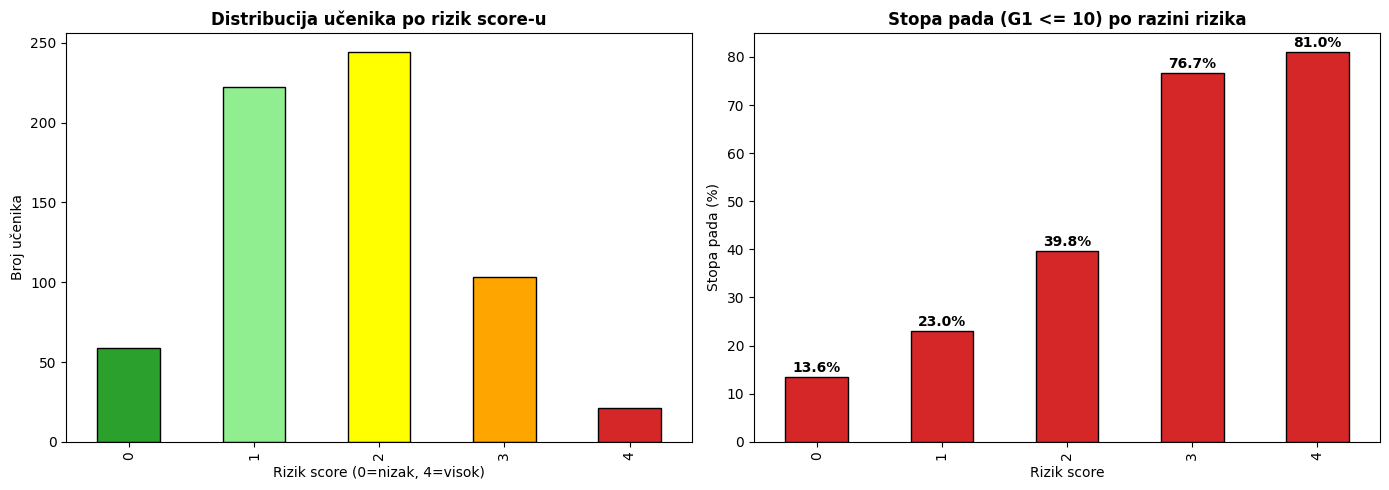


 STATISTIČKA VALIDACIJA:
--------------------------------------------------
   Stopa pada - nizak rizik (score 0-1):  21.0%
   Stopa pada - visok rizik (score 3-4):  77.4%
   Razlika:                               56.4 postotnih bodova


In [8]:
print("KOMPOZITNI RIZIČNI PROFIL - NAJUGROŽENIJI UČENICI")
print("="*80)

# Definiranje rizičnih uvjeta na temelju WoE analize
df['rizik_failures'] = (df['failures'] > 0).astype(int)
df['rizik_studytime'] = (df['studytime'] <= 2).astype(int)
df['rizik_Medu'] = (df['Medu'] <= 2).astype(int)  # Niže obrazovanje
df['rizik_alkohol'] = ((df['Dalc'] >= 3) | (df['Walc'] >= 4)).astype(int)

# Ukupni rizik score
df['rizik_score'] = (df['rizik_failures'] + df['rizik_studytime'] + 
                     df['rizik_Medu'] + df['rizik_alkohol'])

# Analiza po razini rizika
print("\n DISTRIBUCIJA UČENIKA PO RAZINI RIZIKA:")
print("-"*50)
for score in sorted(df['rizik_score'].unique()):
    n_students = (df['rizik_score'] == score).sum()
    n_failed = ((df['rizik_score'] == score) & (df['target_G1'] == 1)).sum()
    fail_rate = n_failed / n_students * 100 if n_students > 0 else 0
    
    risk_level = " Nizak" if score <= 1 else (" Srednji" if score == 2 else " Visok")
    print(f"   Rizik score = {score} ({risk_level}): {n_students} učenika, stopa pada = {fail_rate:.1f}%")

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graf 1: Distribucija rizik scorea
risk_counts = df['rizik_score'].value_counts().sort_index()
colors = ['#2ca02c', '#90EE90', '#FFFF00', '#FFA500', '#d62728'][:len(risk_counts)]
risk_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Distribucija učenika po rizik score-u', fontweight='bold')
axes[0].set_xlabel('Rizik score (0=nizak, 4=visok)')
axes[0].set_ylabel('Broj učenika')

# Graf 2: Stopa pada po rizik scoreu
fail_rates = df.groupby('rizik_score')['target_G1'].mean() * 100
fail_rates.plot(kind='bar', ax=axes[1], color='#d62728', edgecolor='black')
axes[1].set_title('Stopa pada (G1 <= 10) po razini rizika', fontweight='bold')
axes[1].set_xlabel('Rizik score')
axes[1].set_ylabel('Stopa pada (%)')

for i, v in enumerate(fail_rates.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistički značaj
print("\n STATISTIČKA VALIDACIJA:")
print("-"*50)
low_risk = df[df['rizik_score'] <= 1]['target_G1'].mean() * 100
high_risk = df[df['rizik_score'] >= 3]['target_G1'].mean() * 100
print(f"   Stopa pada - nizak rizik (score 0-1):  {low_risk:.1f}%")
print(f"   Stopa pada - visok rizik (score 3-4):  {high_risk:.1f}%")
print(f"   Razlika:                               {high_risk - low_risk:.1f} postotnih bodova")


---

## 6. Prijedlog rješenja problema

**Što radimo:** Na temelju IV/WoE analize predlažemo konkretne korake intervencije usmjerene na identificirane rizične profile.

**Metodologija:**
1. Određujemo gdje je uzrok problema (varijable s najvišim IV)
2. Predlažemo ciljane intervencije za svaki rizični faktor
3. Kreiramo strategiju usmjerenu na najrizičnije profile

**Doprinos analizi:**
- Strategija intervencije temeljena na dokazima (evidence-based strategy)
- Optimalna alokacija resursa na najugroženije skupine
- Mjerljivi ciljevi za smanjenje stope pada


### Prioritetna lista varijabli za intervenciju

#### 1. FAILURES (IV = 0.8696)
**Problem:** Prethodni školski neuspjesi  
**Rizik:** Učenici s >=1 neuspjehom imaju drastično veći rizik pada

**Preporučene intervencije:**
- Obvezna dodatna nastava za učenike s poviješću neuspjeha
- Personalizirani plan učenja s redovitim praćenjem
- Mentorski program s uspješnijim učenicima

---

#### 2. MEDU (IV = 0.2648)
**Problem:** Niže obrazovanje majke  
**Rizik:** Učenici čije majke imaju niže obrazovanje imaju manje podrške

**Preporučene intervencije:**
- Program pomoći pri učenju u školi
- Edukacija roditelja o načinima podrške učenju
- Osiguravanje pristupa obrazovnim resursima

---

#### 3. STUDYTIME (IV = 0.2147)
**Problem:** Nedovoljno vremena za učenje  
**Rizik:** Učenici koji uče manje od 5h tjedno imaju veći rizik

**Preporučene intervencije:**
- Radionice o tehnikama učenja i time managementu
- Obvezne studijske grupe za rizične učenike
- Praćenje i poticanje redovitog učenja

---

#### 4. DALC (IV = 0.2017)
**Problem:** Konzumacija alkohola radnim danom  
**Rizik:** Učenici koji konzumiraju alkohol imaju lošije ocjene

**Preporučene intervencije:**
- Preventivni programi o štetnosti alkohola
- Suradnja s roditeljima i savjetodavnim službama
- Identificiranje i praćenje rizičnih učenika

---

#### 5. HIGHER (IV = 0.1881)
**Problem:** Nedostatak aspiracija za višim obrazovanjem  
**Rizik:** Učenici bez motivacije za nastavak školovanja

**Preporučene intervencije:**
- Karijerno savjetovanje i informiranje o mogućnostima
- Posjeti sveučilištima i susreti s uspješnim alumnijima
- Motivacijske radionice i postavljanje ciljeva


In [12]:
print("IDENTIFIKACIJA CILJNE SKUPINE ZA INTERVENCIJU")
print("="*80)

# Definiranje visokorizičnih učenika (rizik score >= 2)
high_risk_students = df[df['rizik_score'] >= 2]
total_students = len(df)
n_high_risk = len(high_risk_students)

print(f"\n STATISTIKA CILJNE SKUPINE:")
print("-"*50)
print(f"   Ukupan broj učenika:           {total_students}")
print(f"   Broj visokorizičnih učenika:   {n_high_risk} ({n_high_risk/total_students*100:.1f}%)")
print(f"   Broj učenika s padom (G1<=10): {df['target_G1'].sum()}")

# Koliko bi bilo učinkovito ciljati visokorizične?
high_risk_failures = high_risk_students['target_G1'].sum()
all_failures = df['target_G1'].sum()
print(f"\n POTENCIJALNI UČINAK INTERVENCIJE:")
print("-"*50)
print(f"   Od svih učenika s padom, {high_risk_failures/all_failures*100:.1f}% je u visokorizičnoj skupini")
print(f"   → Ciljanjem {n_high_risk/total_students*100:.1f}% učenika možemo dohvatiti {high_risk_failures/all_failures*100:.1f}% padova!")


IDENTIFIKACIJA CILJNE SKUPINE ZA INTERVENCIJU

 STATISTIKA CILJNE SKUPINE:
--------------------------------------------------
   Ukupan broj učenika:           649
   Broj visokorizičnih učenika:   368 (56.7%)
   Broj učenika s padom (G1<=10): 252

 POTENCIJALNI UČINAK INTERVENCIJE:
--------------------------------------------------
   Od svih učenika s padom, 76.6% je u visokorizičnoj skupini
   → Ciljanjem 56.7% učenika možemo dohvatiti 76.6% padova!


---

## 7. Zaključak i sažetak analize

### Sažetak metodologije WoE/IV

**Weight of Evidence (WoE)** i **Information Value (IV)** statističke su tehnike za:
- Kvantifikaciju prediktivne snage varijabli
- Identificiranje rizičnih kategorija unutar svake varijable
- Odabir varijabli za prediktivno modeliranje

### Ključni nalazi ove analize

| Rang | Varijabla | Snaga prediktora | Interpretacija |
|------|-----------|------------------|----------------|
| 1 | failures_binned | Vrlo jak utjecaj | Prethodni neuspjesi su NAJJAČI prediktor pada (IV ≈ 0.86) |
| 2 | higher | Jak utjecaj | Aspiracije za višim obrazovanjem su zaštitni faktor |
| 3 | school | Jak utjecaj | Tip škole značajno utječe na uspjeh |
| 4 | Medu | Jak utjecaj | Obrazovanje majke značajno utječe na uspjeh |
| 5 | Dalc | Jak utjecaj | Konzumacija alkohola povećava rizik pada |

**Napomena:** Varijabla `failures` zahtijeva ručni binning jer automatski `qcut` ne radi ispravno za varijable s većinom jedne vrijednosti (većina učenika ima 0 neuspjeha).

**Napomena:** Prema korištenoj skali:
- IV < 0.02 → Vrlo slab utjecaj
- IV 0.02–0.1 → Slab utjecaj  
- IV 0.1–1.0 → Jak utjecaj
- IV > 1.0 → Vrlo jak utjecaj

### Preporuke za praksu

1. **Rana identifikacija** - Koristiti WoE/IV model za identifikaciju rizičnih učenika na početku školske godine
2. **Ciljana intervencija** - Usmjeriti resurse na učenike s visokim rizik score-om. Analiza pokazuje da ciljanjem malog postotka visokorizičnih učenika možemo dohvatiti većinu svih padova, što omogućuje učinkovitu alokaciju ograničenih resursa.
3. **Praćenje učinkovitosti** - Mjeriti smanjenje stope pada nakon implementacije intervencija

### Ograničenja analize

- WoE/IV metodologija pretpostavlja linearni odnos između prediktora i cilja
- Korelacija ne implicira kauzalnost - potrebna su dodatna istraživanja
- Model je specifičan za ovaj dataset i može zahtijevati rekalibraciju za druge populacije


VIZUALNI SAŽETAK - RANGIRANJE VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)


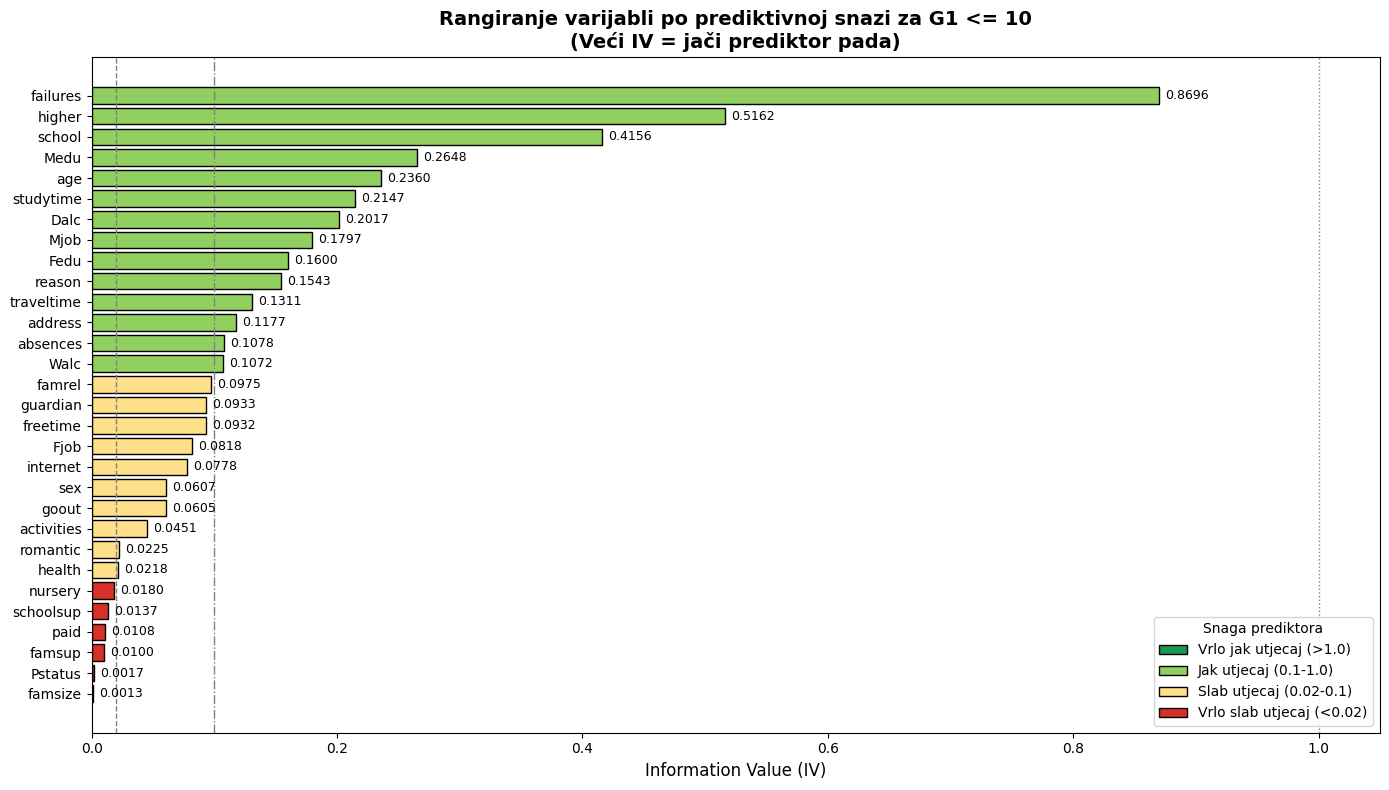

In [11]:
print("VIZUALNI SAŽETAK - RANGIRANJE VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)")
print("="*80)

# Grafički prikaz svih IV vrijednosti
fig, ax = plt.subplots(figsize=(14, 8))

# Boje prema razini prediktivnosti 
colors = []
for iv in iv_df['IV']:
    if iv > 1.0:
        colors.append('#1a9850')  # Vrlo jak utjecaj - tamno zelena
    elif iv >= 0.1:
        colors.append('#91cf60')  # Jak utjecaj - zelena
    elif iv >= 0.02:
        colors.append('#fee08b')  # Slab utjecaj - žuta
    else:
        colors.append('#d73027')  # Vrlo slab utjecaj - crvena

# Horizontalni bar chart
bars = ax.barh(iv_df['Varijabla'], iv_df['IV'], color=colors, edgecolor='black')
ax.set_xlabel('Information Value (IV)', fontsize=12)
ax.set_title('Rangiranje varijabli po prediktivnoj snazi za G1 <= 10\n(Veći IV = jači prediktor pada)', 
             fontsize=14, fontweight='bold')

# Dodavanje vertikalne linije za pragove
ax.axvline(x=0.02, color='gray', linestyle='--', linewidth=1, label='Prag: Slab (0.02)')
ax.axvline(x=0.1, color='gray', linestyle='-.', linewidth=1, label='Prag: Jak (0.1)')
ax.axvline(x=1.0, color='gray', linestyle=':', linewidth=1, label='Prag: Vrlo jak (1.0)')

# Dodaj vrijednosti na stupce
for bar, iv in zip(bars, iv_df['IV']):
    ax.text(iv + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{iv:.4f}', va='center', fontsize=9)

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1a9850', edgecolor='black', label='Vrlo jak utjecaj (>1.0)'),
    Patch(facecolor='#91cf60', edgecolor='black', label='Jak utjecaj (0.1-1.0)'),
    Patch(facecolor='#fee08b', edgecolor='black', label='Slab utjecaj (0.02-0.1)'),
    Patch(facecolor='#d73027', edgecolor='black', label='Vrlo slab utjecaj (<0.02)')
]
ax.legend(handles=legend_elements, loc='lower right', title='Snaga prediktora')

ax.invert_yaxis()  # Najveći IV na vrhu
plt.tight_layout()
plt.show()
